# Evaluate Experiments

---

## Imports

In [1]:
import itertools
import json
import os
import pickle
import random
import re
import string

from pathlib import Path

import contractions
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords

from tqdm import tqdm

In [2]:
STOP_WORDS = set(stopwords.words("english"))

---

## List Experiments 

In [39]:
parent_folder = Path(f"../experiments/")
all_subfolder = os.listdir(parent_folder)

experiments = list()
for sub in all_subfolder:
    folder = parent_folder / sub
    try:
        with open(folder / "grid_params.json", "r") as f:
            grid = json.load(f)
    except FileNotFoundError:
        continue
    with open(folder / "metrics_validation.json", "r") as f:
        val_metrics = json.load(f)
    if os.path.exists(folder / "metrics_test.json"):
        with open(folder / "metrics_test.json", "r") as f:
            test_metrics = json.load(f)
    else:
        test_metrics = dict()
    if os.path.exists(folder / "history.pkl"):
        with open(folder / "history.pkl", "rb") as f:
            history = pickle.load(f)
            actual_epochs = len(history["loss"])
    else:
        actual_epochs = 10
    grid["code"] = sub
    grid["f1_macro"] = val_metrics["f1_macro"]
    grid["f1_test"] = test_metrics.get("f1_macro")
    grid["actual_epoch"] = actual_epochs
    experiments.append(grid)
experiments = (
    pd.DataFrame(experiments)
    .assign(trainable=lambda f: f["trainable"].fillna("all"))
    .assign(dropout=lambda f: f["dropout"].fillna(0.3))
    .assign(label_smoothing=lambda f: f["label_smoothing"].fillna(0))
    .assign(scheduler=lambda f: f["scheduler"].fillna(0.2))
    .sort_values(by=["f1_macro"], ascending=False)
)

In [40]:
experiments.assign(f1_avg=lambda f: f[["f1_macro", "f1_test"]].mean(axis=1)).sort_values(by=["f1_macro"], ascending=False)

,model,head,epochs,batch_size,learning_rate,emoji_tagging,clean_data,balancing,augment,minority_shuffling,code,f1_macro,f1_test,actual_epoch,trainable,dropout,label_smoothing,scheduler,f1_avg
34,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T122042,0.541479,0.509407,10,all,0.3,0.00,0.2,0.525443
36,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T185359,0.541263,0.541996,10,all,0.3,0.00,0.2,0.541629
20,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230729T214900,0.533222,0.514239,10,all,0.3,0.00,0.2,0.523731
24,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230730T091433,0.532132,0.521846,10,all,0.3,0.00,0.2,0.526989
29,bert-base-uncased,none,10,16,0.00005,True,False,[relief],False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T011148,0.531484,0.527949,10,all,0.3,0.00,0.2,0.529717
21,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230729T234627,0.530839,0.524937,10,all,0.3,0.00,0.2,0.527888
30,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T033135,0.530379,0.534527,10,all,0.3,0.00,0.2,0.532453
32,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T075838,0.529260,0.529990,10,all,0.3,0.00,0.2,0.529625
35,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T170250,0.528929,0.527588,10,all,0.3,0.00,0.2,0.528259
31,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230731T053721,0.528771,0.523971,10,all,0.3,0.00,0.2,0.526371


---

## Configs

In [27]:
EXPERIMENT = "20230731T122042"

---

## Load Experiment 

In [28]:
folder = Path(f"../experiments/{EXPERIMENT}")

with open(folder / "grid_params.json", "r") as f:
    grid = json.load(f)
    
    
if os.path.exists(folder / "history.pkl"):
    with open(folder / "history.pkl", "rb") as f:
        history = pickle.load(f)
elif os.path.exists(folder / "history_0.pkl"):
    history_files = [f for f in os.listdir(folder) if "history_" in f]
    history = dict()
    for file in history_files:
        with open(folder / file, "rb") as f:
            history[int(file.split("_")[-1].replace(".pkl", ""))] = pickle.load(f)
else:
    history = None
    
    
with open(folder / "metrics_validation.json", "r") as f:
    val_metrics = json.load(f)
    
    
with open(folder / "confusion_matrix_validation.pkl", "rb") as f:
    val_confusion_matrix = pickle.load(f)

if os.path.exists(folder / "original_predictions.pkl"):
    with open(folder / "original_predictions.pkl", "rb") as f:
        original_predictions = pickle.load(f)
    
data_for_exp = pd.read_pickle(folder / "data_for_exp.pkl")
predictions = pd.read_pickle(folder / "prediction_validation.pkl")
misclassification = pd.read_pickle(folder / "misclassification_validation.pkl")
correct = data_for_exp.loc[lambda f: f["set"] == "validation"].loc[lambda f: ~f["code"].isin(misclassification.code)]

## Experiment Analysis

In [29]:
#### manual record

_ ={
    "loss": [2.1422, 1.6719, 1.4659, 1.4139, 1.4085],
    "f1_score": [0.4444, 0.5766, 0.6309, 0.6459, 0.6479],
    "val_loss": [1.8115, 1.7900, 1.8577, 1.8693, 1.8715],
    "val_f1_score": [0.5483, 0.5632, 0.5634, 0.5626, 0.5626],
    "lr": [5e-5, 1e05, 2e-6, 4e-7, 8e-8],
}

grid

{'model': 'bert-base-uncased',
 'trainable': 'all',
 'head': 'none',
 'scheduler': '0.2',
 'dropout': 0.3,
 'label_smoothing': 0,
 'epochs': 10,
 'batch_size': 16,
 'learning_rate': 5e-05,
 'emoji_tagging': True,
 'clean_data': False,
 'balancing': 'none',
 'augment': False,
 'minority_shuffling': {'grief_sadness': ['grief', 'sadness'],
  'pride_admiration': ['pride', 'admiration'],
  'relief_amusement': ['relief', 'amusement'],
  'nervousness': ['nervousness'],
  'fear': ['fear'],
  'caring': ['caring'],
  'realization': ['realization'],
  'surprise': ['surprise'],
  'joy': ['joy'],
  'neutral': ['neutral'],
  'optimism': ['optimism'],
  'anger': ['anger'],
  'desire': ['desire'],
  'love': ['love'],
  'disapproval': ['disapproval'],
  'approval': ['approval'],
  'excitement': ['excitement'],
  'curiosity': ['curiosity'],
  'embarrassment': ['embarrassment'],
  'disgust': ['disgust'],
  'gratitude': ['gratitude'],
  'annoyance': ['annoyance'],
  'confusion': ['confusion'],
  'disappoi

### Metrics Summary 

In [30]:
print(
    f"Macro F1-Score: {val_metrics['f1_macro']:03f}", 
    f"Micro F1-Score: {val_metrics['f1_micro']:03f}", 
    f"ROC-AUC: {val_metrics['roc_auc']:03f}", 
    sep="\n"
)

Macro F1-Score: 0.541479
Micro F1-Score: 0.604614
ROC-AUC: 0.926268


### History 

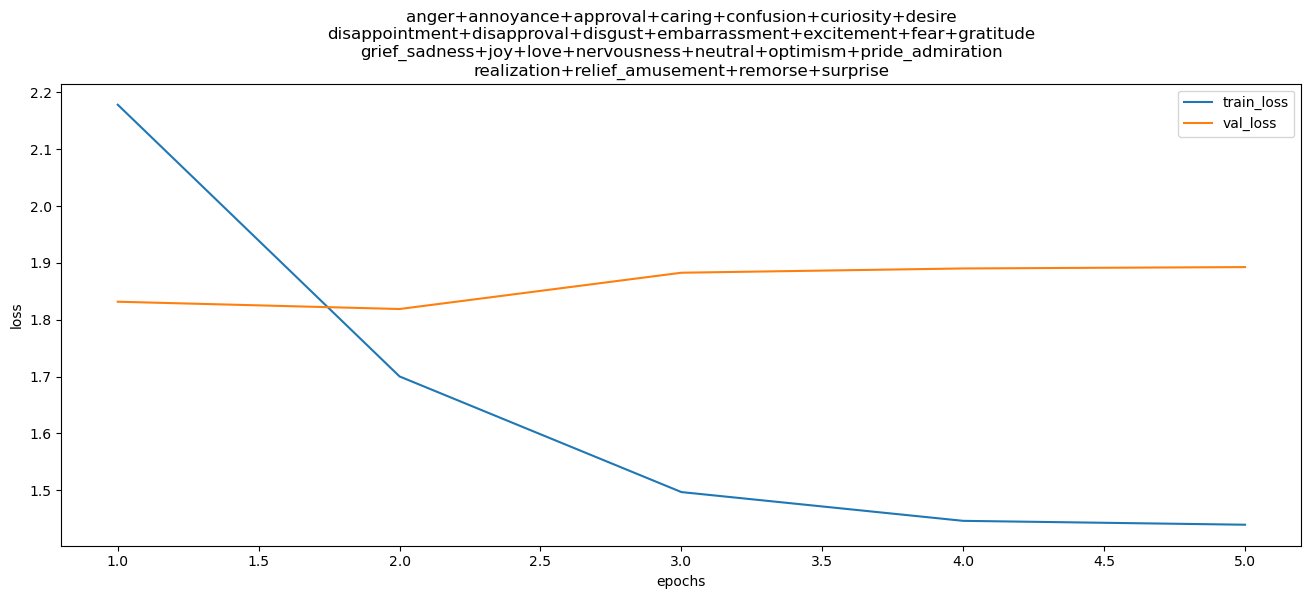

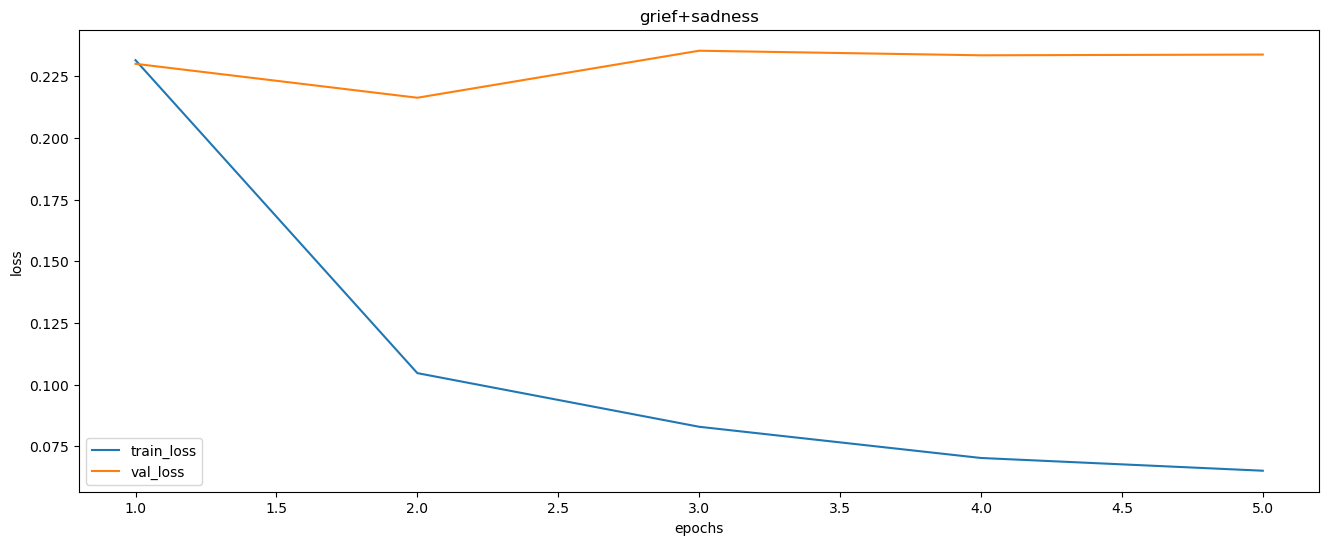

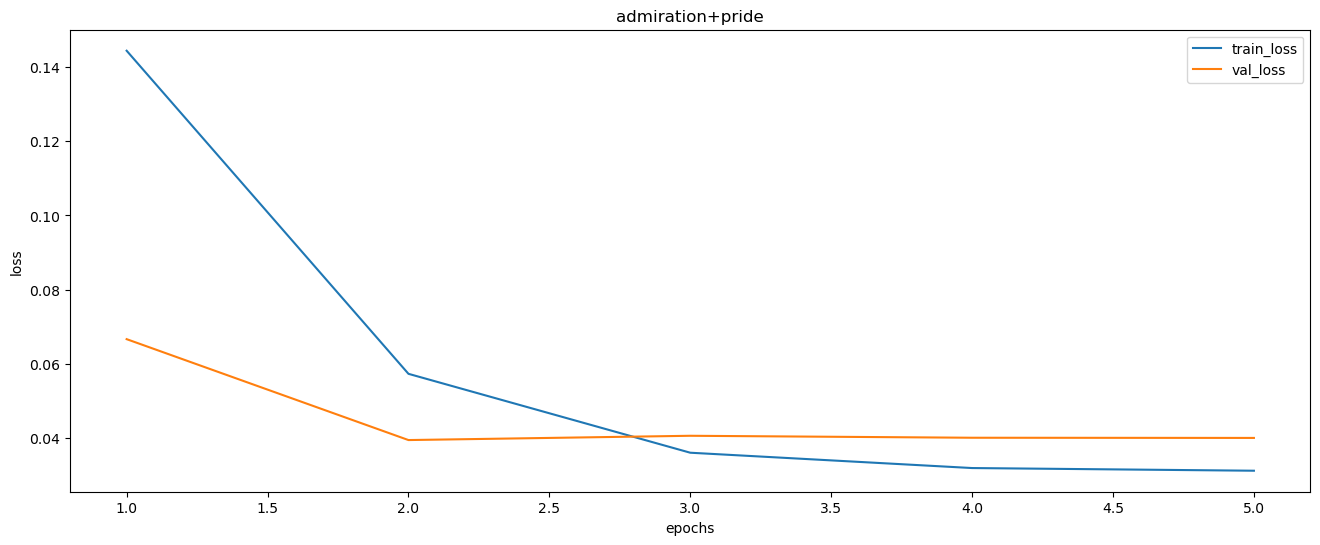

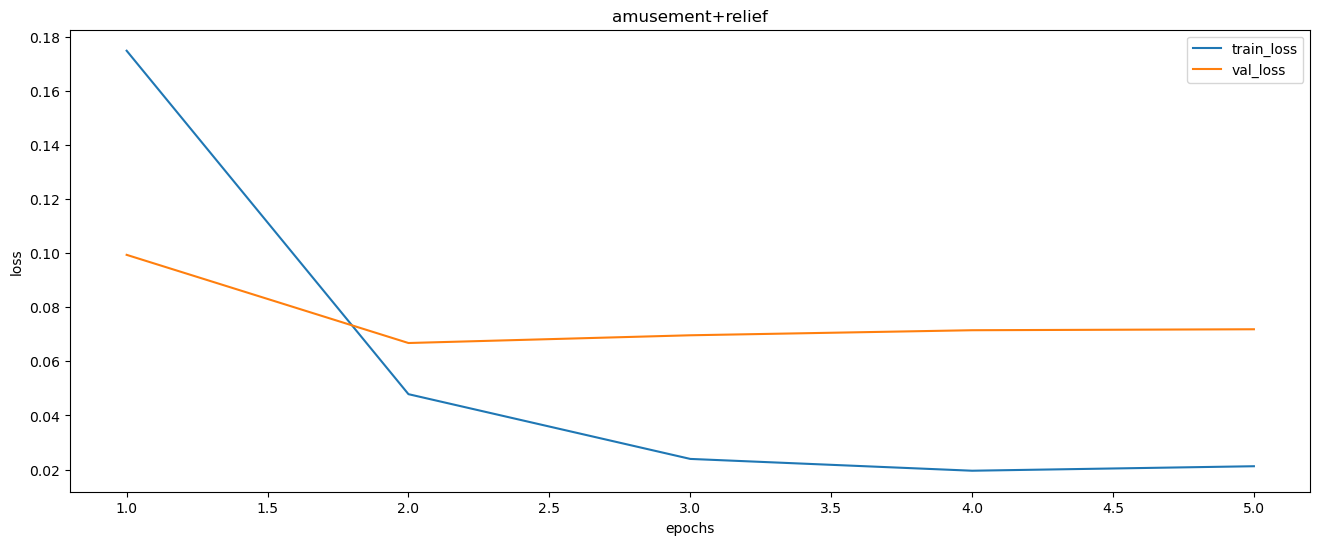

In [31]:
if history is not None:
    if 0 in history:
        for i in history:
            n = 7
            combinations = list(original_predictions)[i]
            title = "\n".join(["+".join(combinations[i:i+n]) for i in range(0, len(combinations), n)])
            df = pd.DataFrame(history[i])
            df.index += 1
            df = df.rename(columns={"loss": "train_loss", "f1_score": "train_f1_score"})
            df.plot(y=["train_loss", "val_loss"], xlabel="epochs", ylabel="loss", title=title, figsize=(16, 6))
    else:
        df = pd.DataFrame(history)
        df.index += 1
        df = df.rename(columns={"loss": "train_loss"})
        df.plot(y=["train_loss", "val_loss"], xlabel="epochs", ylabel="loss", figsize=(16, 6))

### Classification Report 

In [32]:
print(val_metrics["classification_report"])

                precision    recall  f1-score   support

    admiration       0.68      0.81      0.74       488
     amusement       0.75      0.84      0.80       303
         anger       0.42      0.59      0.49       195
     annoyance       0.35      0.53      0.42       303
      approval       0.37      0.41      0.39       397
        caring       0.51      0.54      0.52       153
     confusion       0.45      0.48      0.46       152
     curiosity       0.46      0.69      0.55       248
        desire       0.60      0.52      0.56        77
disappointment       0.38      0.34      0.36       163
   disapproval       0.42      0.43      0.42       292
       disgust       0.43      0.44      0.44        97
 embarrassment       0.70      0.54      0.61        35
    excitement       0.41      0.31      0.35        96
          fear       0.69      0.62      0.65        90
     gratitude       0.91      0.90      0.91       358
         grief       0.46      0.46      0.46  

### Confusion Matrix 

<Axes: >

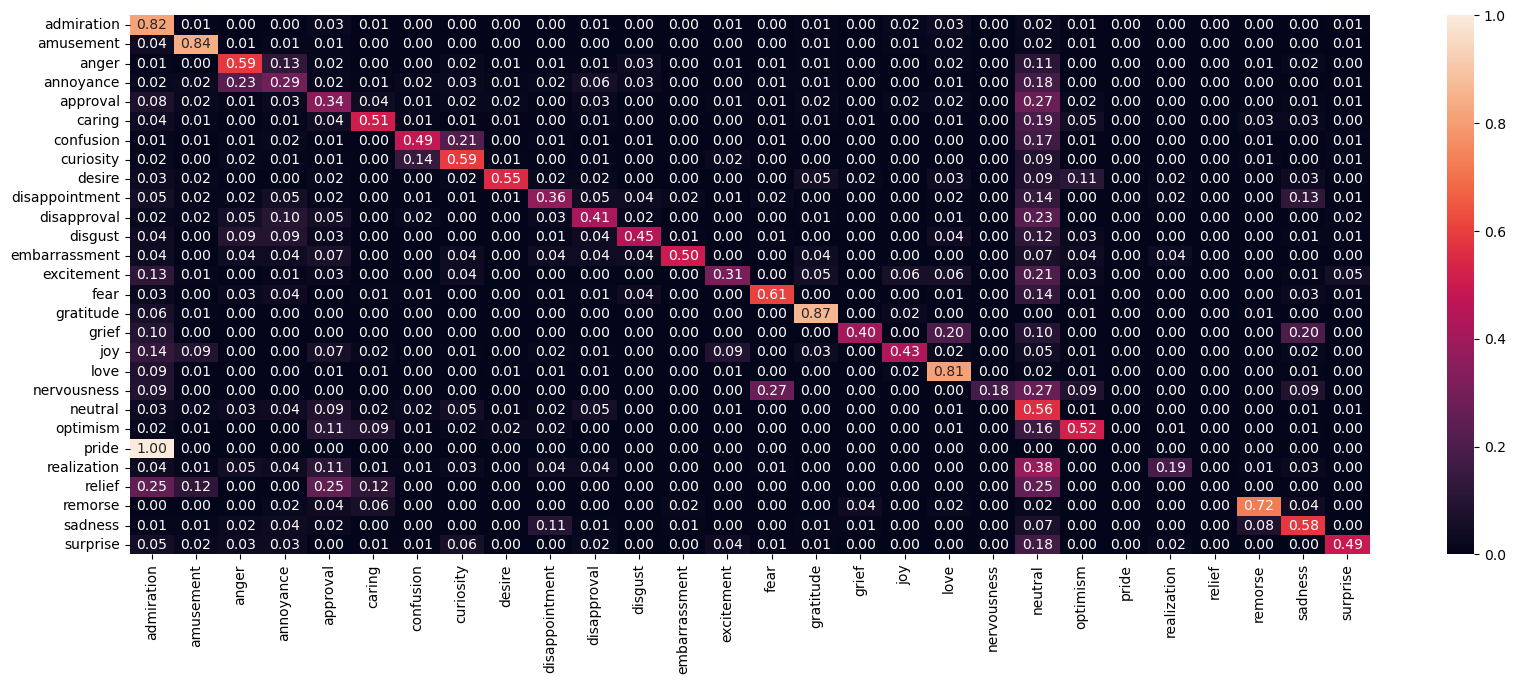

In [10]:
cm = val_confusion_matrix
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    pd.DataFrame(
        cm,
        columns=sorted(list(data_for_exp.goemotion.unique())),
        index=sorted(list(data_for_exp.goemotion.unique()))
    ),
    annot=True,
    fmt="1.2f"
)

### Misclassification Analysis 

In [11]:
PUNCUATION_LIST = list(string.punctuation)

In [12]:
c_dict = list(contractions.slang_dict) + list(contractions.contractions_dict)

In [13]:
for emotion in ["all"] + list(set(data_for_exp.goemotion)):
    results = list()
    for n, df in [("correct", correct), ("misclassified", misclassification)]:
        if emotion != "all":
            df = df.loc[lambda f: f["goemotion"] == emotion]
            
        if df.shape[0] == 0:
            continue
        
        # compute values in the dataset
        df = df.assign(
            chars=lambda f: f["text"].apply(len),
            tokens=lambda f: f["text"].str.split().apply(len),
            emojis=lambda f: f.text.apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA])),
            stop_words=lambda f: f.text.str.split().apply(lambda x: len([t for t in x if t.lower() in STOP_WORDS])),
            high_case=lambda f: f.text.apply(lambda x: len([c for c in x if not c.islower()])),
            contractions=lambda f: f.text.str.split().apply(lambda x: len([t for t in x if t in c_dict])),
            ponctuation=lambda f: f.text.apply(lambda x: len([c for c in x if c in PUNCUATION_LIST])),
        )

        # compile statiscs
        char_length = df["chars"].mean()
        tokens = df["tokens"].mean()
        high_case_rate = df.high_case.sum() / df.chars.sum()
        emoji_rate = df.emojis.sum() / df.chars.sum()
        stop_words = df["stop_words"].sum() / df["tokens"].sum()
        contractions = df["contractions"].sum() / df["tokens"].sum()
        ponctuations = df["ponctuation"].sum() / df["chars"].sum()

        results.append({
            "type": n,
            "char_length": char_length,
            "token_length": tokens,
            "case_rate": high_case_rate,
            "ponctuations_rate": ponctuations,
            "emoji_rate": emoji_rate,
            "stop_words_rate": stop_words,
            "contraction_rate": contractions
        })

    display(
        pd.DataFrame(results)
        .set_index(["type"]).T
        .assign(emotion=emotion)
        .reindex(columns=["emotion", "correct", "misclassified"])
        .assign(delta=lambda f: f["misclassified"] - f["correct"])
        .assign(rate=lambda f: f["misclassified"] / f["correct"])
    )

type,emotion,correct,misclassified,delta,rate
char_length,all,65.346328,73.983943,8.637615,1.132182
token_length,all,12.244068,13.882248,1.638180,1.133794
case_rate,all,0.267104,0.265464,-0.001640,0.993861
ponctuations_rate,all,0.040190,0.039090,-0.001100,0.972639
emoji_rate,all,0.000454,0.000796,0.000342,1.753218
stop_words_rate,all,0.437569,0.441139,0.003569,1.008157
contraction_rate,all,0.028862,0.031262,0.002400,1.083151


type,emotion,correct,misclassified,delta,rate
char_length,realization,78.434783,85.608247,7.173465,1.091458
token_length,realization,14.391304,16.072165,1.680861,1.116797
case_rate,realization,0.261641,0.262645,0.001004,1.003836
ponctuations_rate,realization,0.041574,0.035645,-0.005929,0.857392
emoji_rate,realization,0.000000,0.000723,0.000723,inf
stop_words_rate,realization,0.486405,0.462476,-0.023929,0.950805
contraction_rate,realization,0.027190,0.025657,-0.001533,0.943625


type,emotion,correct,misclassified,delta,rate
char_length,disappointment,77.190476,76.207207,-0.983269,0.987262
token_length,disappointment,14.190476,14.558559,0.368082,1.025939
case_rate,disappointment,0.260333,0.258187,-0.002147,0.991754
ponctuations_rate,disappointment,0.036089,0.037120,0.001031,1.028579
emoji_rate,disappointment,0.000000,0.000236,0.000236,inf
stop_words_rate,disappointment,0.432886,0.443688,0.010802,1.024954
contraction_rate,disappointment,0.040268,0.034035,-0.006234,0.845194


type,emotion,correct,misclassified,delta,rate
char_length,fear,56.090909,77.567568,21.476658,1.382890
token_length,fear,10.500000,13.729730,3.229730,1.307593
case_rate,fear,0.253241,0.243206,-0.010036,0.960370
ponctuations_rate,fear,0.036467,0.038328,0.001861,1.051026
emoji_rate,fear,0.000000,0.000000,0.000000,NaN
stop_words_rate,fear,0.456710,0.409449,-0.047261,0.896518
contraction_rate,fear,0.025974,0.027559,0.001585,1.061024


type,emotion,correct,misclassified,delta,rate
char_length,grief,49.000000,76.000000,27.000000,1.551020
token_length,grief,10.000000,14.375000,4.375000,1.437500
case_rate,grief,0.229592,0.256579,0.026987,1.117544
ponctuations_rate,grief,0.015306,0.041118,0.025812,2.686404
emoji_rate,grief,0.000000,0.000000,0.000000,NaN
stop_words_rate,grief,0.425000,0.408696,-0.016304,0.961637
contraction_rate,grief,0.000000,0.026087,0.026087,inf


type,emotion,correct,misclassified,delta,rate
char_length,disapproval,67.834783,78.578616,10.743834,1.158382
token_length,disapproval,12.486957,14.553459,2.066503,1.165493
case_rate,disapproval,0.253814,0.265007,0.011194,1.044102
ponctuations_rate,disapproval,0.038841,0.035137,-0.003704,0.904629
emoji_rate,disapproval,0.000385,0.000480,0.000096,1.248759
stop_words_rate,disapproval,0.462396,0.451167,-0.011229,0.975716
contraction_rate,disapproval,0.052925,0.040190,-0.012735,0.759382


type,emotion,correct,misclassified,delta,rate
char_length,neutral,65.187841,71.004975,5.817134,1.089236
token_length,neutral,12.098987,13.338308,1.239322,1.102432
case_rate,neutral,0.270781,0.270320,-0.000461,0.998297
ponctuations_rate,neutral,0.040760,0.039798,-0.000962,0.976404
emoji_rate,neutral,0.000359,0.001086,0.000727,3.027742
stop_words_rate,neutral,0.439606,0.432115,-0.007491,0.982960
contraction_rate,neutral,0.025961,0.036367,0.010406,1.400807


type,emotion,correct,misclassified,delta,rate
char_length,nervousness,80.166667,79.000000,-1.166667,0.985447
token_length,nervousness,14.000000,14.928571,0.928571,1.066327
case_rate,nervousness,0.234927,0.254973,0.020046,1.085327
ponctuations_rate,nervousness,0.033264,0.039783,0.006519,1.195976
emoji_rate,nervousness,0.000000,0.000000,0.000000,NaN
stop_words_rate,nervousness,0.440476,0.454545,0.014069,1.031941
contraction_rate,nervousness,0.095238,0.038278,-0.056961,0.401914


type,emotion,correct,misclassified,delta,rate
char_length,pride,58.666667,64.000000,5.333333,1.090909
token_length,pride,11.500000,12.285714,0.785714,1.068323
case_rate,pride,0.250000,0.243304,-0.006696,0.973214
ponctuations_rate,pride,0.042614,0.035714,-0.006899,0.838095
emoji_rate,pride,0.000000,0.000000,0.000000,NaN
stop_words_rate,pride,0.478261,0.441860,-0.036400,0.923890
contraction_rate,pride,0.028986,0.069767,0.040782,2.406977


type,emotion,correct,misclassified,delta,rate
char_length,embarrassment,65.181818,83.722222,18.540404,1.284441
token_length,embarrassment,11.818182,15.555556,3.737374,1.316239
case_rate,embarrassment,0.252441,0.239549,-0.012892,0.948931
ponctuations_rate,embarrassment,0.039052,0.033842,-0.005210,0.866599
emoji_rate,embarrassment,0.000000,0.000664,0.000664,inf
stop_words_rate,embarrassment,0.446154,0.457143,0.010989,1.024631
contraction_rate,embarrassment,0.015385,0.021429,0.006044,1.392857


type,emotion,correct,misclassified,delta,rate
char_length,disgust,77.763158,80.098039,2.334881,1.030026
token_length,disgust,14.000000,14.686275,0.686275,1.049020
case_rate,disgust,0.254484,0.240636,-0.013847,0.945586
ponctuations_rate,disgust,0.038240,0.032069,-0.006172,0.838607
emoji_rate,disgust,0.000338,0.000490,0.000151,1.446756
stop_words_rate,disgust,0.437970,0.433912,-0.004058,0.990734
contraction_rate,disgust,0.022556,0.026702,0.004146,1.183801


type,emotion,correct,misclassified,delta,rate
char_length,annoyance,72.591304,73.380000,0.788696,1.010865
token_length,annoyance,13.408696,13.606667,0.197971,1.014764
case_rate,annoyance,0.250479,0.257473,0.006993,1.027920
ponctuations_rate,annoyance,0.037135,0.040156,0.003022,1.081369
emoji_rate,annoyance,0.000000,0.000545,0.000545,inf
stop_words_rate,annoyance,0.455253,0.446350,-0.008903,0.980444
contraction_rate,annoyance,0.034371,0.038707,0.004336,1.126141


type,emotion,correct,misclassified,delta,rate
char_length,remorse,68.333333,89.700000,21.366667,1.312683
token_length,remorse,12.777778,16.500000,3.722222,1.291304
case_rate,remorse,0.278862,0.239688,-0.039174,0.859522
ponctuations_rate,remorse,0.052033,0.033445,-0.018588,0.642768
emoji_rate,remorse,0.000407,0.000000,-0.000407,0.000000
stop_words_rate,remorse,0.406522,0.472727,0.066206,1.162859
contraction_rate,remorse,0.041304,0.048485,0.007181,1.173844


type,emotion,correct,misclassified,delta,rate
char_length,confusion,76.491228,81.135802,4.644574,1.060720
token_length,confusion,14.877193,15.444444,0.567251,1.038129
case_rate,confusion,0.263761,0.282106,0.018344,1.069549
ponctuations_rate,confusion,0.036697,0.043518,0.006821,1.185864
emoji_rate,confusion,0.000000,0.000000,0.000000,NaN
stop_words_rate,confusion,0.501179,0.473221,-0.027958,0.944216
contraction_rate,confusion,0.049528,0.023181,-0.026347,0.468045


type,emotion,correct,misclassified,delta,rate
char_length,amusement,61.927184,66.955556,5.028371,1.081198
token_length,amusement,11.679612,12.533333,0.853722,1.073095
case_rate,amusement,0.257192,0.268503,0.011311,1.043979
ponctuations_rate,amusement,0.035275,0.046465,0.011191,1.317240
emoji_rate,amusement,0.000705,0.003651,0.002945,5.174872
stop_words_rate,amusement,0.418537,0.414894,-0.003643,0.991295
contraction_rate,amusement,0.028263,0.026596,-0.001667,0.941020


type,emotion,correct,misclassified,delta,rate
char_length,caring,66.895522,75.546667,8.651144,1.129323
token_length,caring,12.447761,14.373333,1.925572,1.154692
case_rate,caring,0.250112,0.254148,0.004036,1.016137
ponctuations_rate,caring,0.040161,0.035828,-0.004333,0.892111
emoji_rate,caring,0.000223,0.000353,0.000130,1.582068
stop_words_rate,caring,0.430456,0.449907,0.019452,1.045188
contraction_rate,caring,0.034772,0.032468,-0.002305,0.933721


type,emotion,correct,misclassified,delta,rate
char_length,relief,NaN,70.500000,NaN,NaN
token_length,relief,NaN,13.166667,NaN,NaN
case_rate,relief,NaN,0.292356,NaN,NaN
ponctuations_rate,relief,NaN,0.041765,NaN,NaN
emoji_rate,relief,NaN,0.000000,NaN,NaN
stop_words_rate,relief,NaN,0.400844,NaN,NaN
contraction_rate,relief,NaN,0.033755,NaN,NaN


type,emotion,correct,misclassified,delta,rate
char_length,gratitude,57.992481,72.435897,14.443416,1.249057
token_length,gratitude,10.845865,13.641026,2.795161,1.257717
case_rate,gratitude,0.271036,0.265841,-0.005195,0.980832
ponctuations_rate,gratitude,0.044276,0.041416,-0.002860,0.935406
emoji_rate,gratitude,0.000324,0.000354,0.000030,1.092106
stop_words_rate,gratitude,0.417331,0.400376,-0.016955,0.959373
contraction_rate,gratitude,0.026343,0.024436,-0.001907,0.927607


type,emotion,correct,misclassified,delta,rate
char_length,joy,72.883117,68.805195,-4.077922,0.944048
token_length,joy,13.922078,13.129870,-0.792208,0.943097
case_rate,joy,0.271205,0.268403,-0.002801,0.989671
ponctuations_rate,joy,0.042053,0.039638,-0.002415,0.942569
emoji_rate,joy,0.000535,0.000566,0.000032,1.059268
stop_words_rate,joy,0.422575,0.448071,0.025497,1.060336
contraction_rate,joy,0.039179,0.024728,-0.014451,0.631153


type,emotion,correct,misclassified,delta,rate
char_length,surprise,82.169492,65.120690,-17.048802,0.792517
token_length,surprise,15.186441,12.396552,-2.789889,0.816291
case_rate,surprise,0.261757,0.297855,0.036098,1.137906
ponctuations_rate,surprise,0.038160,0.048186,0.010026,1.262744
emoji_rate,surprise,0.000619,0.000530,-0.000089,0.855706
stop_words_rate,surprise,0.445312,0.414465,-0.030848,0.930727
contraction_rate,surprise,0.050223,0.036161,-0.014062,0.720012


type,emotion,correct,misclassified,delta,rate
char_length,excitement,53.120000,56.578125,3.458125,1.065100
token_length,excitement,10.040000,10.328125,0.288125,1.028698
case_rate,excitement,0.310994,0.282519,-0.028475,0.908438
ponctuations_rate,excitement,0.051205,0.053576,0.002372,1.046315
emoji_rate,excitement,0.000000,0.001105,0.001105,inf
stop_words_rate,excitement,0.382470,0.387292,0.004822,1.012607
contraction_rate,excitement,0.051793,0.027231,-0.024561,0.525777


type,emotion,correct,misclassified,delta,rate
char_length,curiosity,62.389262,75.250000,12.860738,1.206137
token_length,curiosity,11.738255,14.210526,2.472271,1.210617
case_rate,curiosity,0.271192,0.264557,-0.006635,0.975533
ponctuations_rate,curiosity,0.045288,0.040741,-0.004547,0.899601
emoji_rate,curiosity,0.000108,0.000350,0.000242,3.250918
stop_words_rate,curiosity,0.476272,0.468519,-0.007754,0.983720
contraction_rate,curiosity,0.026872,0.031481,0.004609,1.171513


type,emotion,correct,misclassified,delta,rate
char_length,optimism,78.927083,78.819277,-0.107806,0.998634
token_length,optimism,15.020833,14.771084,-0.249749,0.983373
case_rate,optimism,0.259337,0.258331,-0.001007,0.996118
ponctuations_rate,optimism,0.035634,0.036227,0.000593,1.016650
emoji_rate,optimism,0.000000,0.000917,0.000917,inf
stop_words_rate,optimism,0.448682,0.441272,-0.007410,0.983485
contraction_rate,optimism,0.029820,0.029364,-0.000456,0.984711


type,emotion,correct,misclassified,delta,rate
char_length,sadness,65.875000,81.808511,15.933511,1.241875
token_length,sadness,12.986111,15.255319,2.269208,1.174741
case_rate,sadness,0.283576,0.266580,-0.016996,0.940066
ponctuations_rate,sadness,0.044908,0.043953,-0.000955,0.978732
emoji_rate,sadness,0.001476,0.001040,-0.000436,0.704886
stop_words_rate,sadness,0.448128,0.423989,-0.024139,0.946133
contraction_rate,sadness,0.031016,0.034868,0.003851,1.124176


type,emotion,correct,misclassified,delta,rate
char_length,admiration,63.148265,69.604396,6.456131,1.102238
token_length,admiration,11.671924,13.230769,1.558845,1.133555
case_rate,admiration,0.255970,0.259552,0.003582,1.013994
ponctuations_rate,admiration,0.038266,0.036470,-0.001796,0.953072
emoji_rate,admiration,0.000300,0.000316,0.000016,1.053468
stop_words_rate,admiration,0.408649,0.434385,0.025737,1.062980
contraction_rate,admiration,0.022162,0.024917,0.002755,1.124301


type,emotion,correct,misclassified,delta,rate
char_length,anger,56.189474,69.333333,13.143860,1.233920
token_length,anger,10.673684,12.790123,2.116439,1.198286
case_rate,anger,0.300300,0.274217,-0.026083,0.913143
ponctuations_rate,anger,0.045148,0.038462,-0.006686,0.851899
emoji_rate,anger,0.000562,0.000178,-0.000384,0.316833
stop_words_rate,anger,0.429980,0.445946,0.015966,1.037131
contraction_rate,anger,0.021696,0.023166,0.001470,1.067743


type,emotion,correct,misclassified,delta,rate
char_length,love,62.502793,70.700000,8.197207,1.131149
token_length,love,12.407821,13.450000,1.042179,1.083994
case_rate,love,0.284144,0.269448,-0.014695,0.948282
ponctuations_rate,love,0.038613,0.040311,0.001698,1.043985
emoji_rate,love,0.002503,0.004243,0.001741,1.695494
stop_words_rate,love,0.431337,0.423792,-0.007545,0.982507
contraction_rate,love,0.019361,0.018587,-0.000773,0.960059


type,emotion,correct,misclassified,delta,rate
char_length,desire,51.090909,75.611111,24.520202,1.479933
token_length,desire,10.818182,15.222222,4.404040,1.407096
case_rate,desire,0.310202,0.289126,-0.021076,0.932057
ponctuations_rate,desire,0.040332,0.038942,-0.001390,0.965531
emoji_rate,desire,0.000593,0.001102,0.000509,1.858193
stop_words_rate,desire,0.459384,0.472628,0.013244,1.028830
contraction_rate,desire,0.036415,0.023723,-0.012692,0.651460


type,emotion,correct,misclassified,delta,rate
char_length,approval,68.966387,73.926070,4.959683,1.071915
token_length,approval,12.848739,13.824903,0.976163,1.075973
case_rate,approval,0.251858,0.264856,0.012998,1.051608
ponctuations_rate,approval,0.038626,0.038370,-0.000255,0.993395
emoji_rate,approval,0.000366,0.001316,0.000950,3.599751
stop_words_rate,approval,0.437541,0.443006,0.005465,1.012490
contraction_rate,approval,0.024199,0.027301,0.003102,1.128190


### Phrase Example 

In [14]:
for e, p in val_metrics["misclassification_examples"].items():
    print("=" * 125)
    print(e)
    print("=" * 125)
    for v in p:
        print(v)
        print()

admiration
Just made my first robocough purchase. Glad I used the website

I love the people who confuse this sub for some kind of "intellectual" gathering lmao

To be fair, you have to have a staggeringly high IQ to understand the Dead Parrot Sketch.

amusement
The comments on this have me rolling 🤣 more seriously though, I hope everyone’s alright!! ❤️

Haha yep. Thanks. Fixed it!

A thousand times this! I just found some of my old childhood stuff from the 80s with a 2 bar and it is fucking awesome.

anger
You forgot about the [NAME] congresswoman.

Some idiot talks shit to one woman - > SOCIETY shames WOMEN for BEING ALIVE

You're the one who's out, biggy. Out of your mind!

annoyance
How come nobody even reacted?

Ahh change.org, where change goes to...do nothing

Yikes. Was he unfamiliar with the area? How did it go over at work?

approval
Women should be able to make their own decisions about their bodies. They are conscious when their fetuses are not. Their priorities matter more

---